### Initial package imports

In [1]:
import pandas as pd
import math
import scipy.stats as st
import numpy as np

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)


In [3]:
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    daily_rate = ((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates


## Portfolio details

### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

### Invested amount:
- **10,000,000 EURO**

### Period:
- **01/01/2012 - 31/12/2022**

### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



In [4]:
main_df


,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,C_Dax40_Loss,C_Nikkei_Loss,USD/EUR,JPY/EUR,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.772500,0.010070,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.000107
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,15.560000,0.722568,0.782100,0.010120,05 Jan 2012,2.784807,1500160.221773,160.221773,-160.221773,0.000107
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,38.070000,1.004256,0.786100,0.010210,06 Jan 2012,2.788371,1500320.665733,160.443961,-160.443961,0.000107
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,40.690000,0.000000,0.783300,0.010190,09 Jan 2012,2.757489,1500479.349701,158.683968,-158.683968,0.000106
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,-145.750000,-0.325163,0.782600,0.010190,10 Jan 2012,2.746027,1500637.390784,158.041083,-158.041083,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,-26.860000,1.933148,0.939700,0.007039,23 Dec 2022,2.464312,1616021.850779,152.734463,-152.734463,0.000095
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,-54.170000,-0.295638,0.937900,0.007051,27 Dec 2022,2.501054,1616176.877110,155.026331,-155.026331,0.000096
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,69.500000,0.752234,0.934100,0.007123,28 Dec 2022,2.522043,1616333.219428,156.342318,-156.342318,0.000097
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,-146.120000,1.740398,NaN,NaN,29 Dec 2022,2.526705,1616489.865897,156.646469,-156.646469,0.000097


## Portfolio values 

In [5]:
# initial investment 
weigths = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weigths['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weigths['DAX40']
invested_amount_NIKKEI = starting_investment * weigths['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weigths['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)


[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


## Returns Portfolio 

In [6]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 

main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']


In [7]:
main_df

,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.000107,NaN,NaN,NaN,1500000.000000
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,05 Jan 2012,2.784807,1500160.221773,160.221773,-160.221773,0.000107,5189897.180583,2992352.262000,148944667.328699,1500160.221773
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,06 Jan 2012,2.788371,1500320.665733,160.443961,-160.443961,0.000107,5179533.786296,2973606.159562,148926943.509066,1500320.665733
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,09 Jan 2012,2.757489,1500479.349701,158.683968,-158.683968,0.000106,5188699.359796,2953565.582481,148926943.509066,1500479.349701
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,10 Jan 2012,2.746027,1500637.390784,158.041083,-158.041083,0.000105,5224622.209432,3024254.466714,148932706.981779,1500637.390784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,23 Dec 2022,2.464312,1616021.850779,152.734463,-152.734463,0.000095,11203387.897754,5587239.551284,150353000.311487,1616021.850779
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,27 Dec 2022,2.501054,1616176.877110,155.026331,-155.026331,0.000096,11160667.822429,5608907.709937,150354684.265090,1616176.877110
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,28 Dec 2022,2.522043,1616333.219428,156.342318,-156.342318,0.000097,11033498.028193,5580984.351838,150350399.156588,1616333.219428
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,29 Dec 2022,2.526705,1616489.865897,156.646469,-156.646469,0.000097,11212633.819784,5639239.989196,150340415.890085,1616489.865897


## Input values 

### Expected returns (daily)

In [8]:
Mu_SP500 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Returns'].mean() 
Mu_DAX40= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Returns'].mean() 
Mu_NIKKEI= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Returns'].mean() 
Mu_EU_BOND= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['Interest_Bond_daily_rate'].mean() 
Mu= [Mu_SP500, Mu_DAX40, Mu_NIKKEI, Mu_EU_BOND]  
Pmu = weigths['S&P500'] * Mu_SP500 + weigths['DAX40'] * Mu_DAX40 + weigths['NIKKEI'] * Mu_NIKKEI + weigths['EU-BOND'] * Mu_EU_BOND
print(Mu)
print(Pmu)

[np.float64(0.0004334705374950923), np.float64(0.0003792732422457793), np.float64(3.917385512367491e-06), np.float64(2.460743025741382e-05)]
0.0002914489100372379


### Variances

In [9]:
## variances
var_SP500 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Returns'].var()
var_DAX40 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Returns'].var()
var_NIKKEI = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Returns'].var()
var_EU_BOND = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['Interest_Bond_daily_rate'].var()
variances = [var_SP500, var_DAX40, var_NIKKEI, var_EU_BOND] 
print(variances)

[np.float64(7.823373341137111e-05), np.float64(0.00014538113320003), np.float64(1.0313971712407492e-08), np.float64(1.2151321021366375e-09)]


### Covariance matrix 

In [10]:
# Filter the data for the relevant date range
filtered_df = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

# Select the relevant columns for returns
Returns = filtered_df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']]

# Compute the covariance matrix
CovM = Returns.cov()

# Compute the correlation matrix
CorrM = Returns.corr()

# Print the covariance matrix
print("Covariance Matrix:")
print(CovM)

# Print the correlation matrix
print("\n")  # Add a blank line for better readability
print("Correlation Matrix:")
print(CorrM)


Covariance Matrix:
                          C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
C_S&P500_Returns                  0.000078         0.000063          0.000000   
C_Dax40_Returns                   0.000063         0.000145          0.000000   
C_Nikkei_Returns                  0.000000         0.000000          0.000000   
Interest_Bond_daily_rate         -0.000000         0.000000          0.000000   

                          Interest_Bond_daily_rate  
C_S&P500_Returns                         -0.000000  
C_Dax40_Returns                           0.000000  
C_Nikkei_Returns                          0.000000  
Interest_Bond_daily_rate                  0.000000  


Correlation Matrix:
                          C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
C_S&P500_Returns                  1.000000         0.589185          0.189941   
C_Dax40_Returns                   0.589185         1.000000          0.309195   
C_Nikkei_Returns                  0.189941   

### Portfolio variance/standard deviation 

In [11]:
# Convert weights to a numpy array
weights = np.array([weigths['S&P500'], weigths['DAX40'], weigths['NIKKEI'], weigths['EU-BOND']])

# Calculate the portfolio variance
Pvar = np.dot(weights.T, np.dot(CovM.values, weights))
Pvol = np.sqrt(Pvar)

print(Pvar)
print(Pvol)

4.073743379964461e-05
0.006382588330735785


# Value at Risk (VaR)

In [12]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)

        dVaR= r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0

    return dVaR

# Expected Shortfall (ES)

In [13]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0

    return dES

In [14]:
def main():
    # Magic numbers
    vN = len(main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')])
    P = 50
    dMu = Pmu  #must be estimated via GARCH
    dSy= Pvol #must be estimated via GARCH
    vAlpha= [.95, .99]
    iDF= 6

    # Initialisation
    vAlpha= np.array(vAlpha)

    # Estimation
    vVaR= VaR(vAlpha, dMu, dSy)
    vVaRt= VaR(vAlpha, dMu, dSy, df= iDF)
    print ('var, vart:', vVaR, vVaRt)

    vES= ES(vAlpha, dMu, dSy)
    vESt= ES(vAlpha, dMu, dSy, df= iDF)
    print ('es, est:', vES, vESt)

    vN= dMu+dSy*st.norm.rvs(size= 10000000)
    print (f'Simulating Norm, mean= {vN.mean()}, std= {vN.std()}')

    dVaRs= np.quantile(vN, .95)
    vI= vN >= dVaRs
    print (f'Sim, var= {dVaRs}, ES= {vN[vI].mean()}')

    dS2t= iDF/(iDF-2)
    dC= dSy / np.sqrt(dS2t)
    vT= dMu+dC*st.t.rvs(df= iDF, size= 10000000)
    print (f'Simulating t({iDF}), mean= {vT.mean()}, std= {vT.std()}')

    dVaRt= np.quantile(vT, .95)
    vI= vT >= dVaRt
    print (f'Sim, vart= {dVaRt}, ES= {vT[vI].mean()}')

    np.quantile(vT, .99)
    VaR(.95, 0, 1)


In [15]:
main()

var, vart: [0.01078987 0.01513957] [0.01041806 0.01666903]
es, est: [0.0134569  0.01730241] [0.01441809 0.02130641]
Simulating Norm, mean= 0.0002909410844396448, std= 0.006382555627111977
Sim, var= 0.01078656012122206, ES= 0.01345272334675292
Simulating t(6), mean= 0.0002933496418892932, std= 0.006387568153069916
Sim, vart= 0.010422008376553176, ES= 0.014433556503736724


# For Loop

In [16]:
def calculate_mean_return(window, current_date):
    """
    Calculate the mean returns for each index and the portfolio mean return.
    """
    return {
        'Date': current_date,
        'SP500_Mean_Return': window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': window['Interest_Bond_daily_rate'].mean(),
        'Portfolio_Mean_Return': (
            weigths['S&P500'] * window['C_S&P500_Returns'].mean() +
            weigths['DAX40'] * window['C_Dax40_Returns'].mean() +
            weigths['NIKKEI'] * window['C_Nikkei_Returns'].mean() +
            weigths['EU-BOND'] * window['Interest_Bond_daily_rate'].mean()
        )
    }

In [17]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

In [18]:
def calculate_VaR(Alpha, mean_return, variance_return, DF):
    if DF == 0:
        crit_val = st.norm.ppf(Alpha)
        VaR = mean_return['Portfolio_Mean_Return'] + variance_return['Portfolio_Volatility'] * crit_val
    else:
        crit_val = st.t.ppf(Alpha, df=DF)
        scale = variance_return['Portfolio_Volatility'] / np.sqrt(DF / (DF - 2))
        VaR = mean_return['Portfolio_Mean_Return'] + scale * crit_val
    return VaR

In [19]:
def calculate_ES(vAlpha, mean_return, variance_return, DF):
    if DF == 0:
        crit_val = st.norm.ppf(vAlpha)
        crit_val_ES = st.norm.pdf(crit_val) / (1 - vAlpha)
            
        ES_value = mean_return['Portfolio_Mean_Return'] + variance_return['Portfolio_Volatility'] * crit_val_ES
    else:
        crit_val = st.t.ppf(vAlpha, df=DF)
        crit_val_ES = st.t.pdf(crit_val, df=DF) * ((DF + crit_val ** 2) / (DF - 1)) / (1 - vAlpha) 
        scale = variance_return['Portfolio_Volatility'] / np.sqrt(DF / (DF - 2))
            
        ES_value = mean_return['Portfolio_Mean_Return'] + scale * crit_val_ES

    return ES_value

In [20]:
# Initialize lists to store results
mean_returns = []
variance_returns = []
VaR_results = []
ES_results = []  # List to store VaR results
time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

vAlpha= [.95, .99]
DF= 0

# Initialisation
vAlpha= np.array(vAlpha)

# Iterate through the DataFrame with a rolling window of 500 days
sample_size = 500

for i in range(sample_size, len(time_window)):
    # Extract the window of 500 days
    window = time_window.iloc[i - sample_size:i]
    current_date = time_window.iloc[i]['Date']
    
    # Calculate mean and variance returns using the functions
    mean_return = calculate_mean_return(window, current_date)
    variance_return = calculate_variance_return(window, current_date, weights)
    
    # Append the results to the lists
    mean_returns.append(mean_return)
    variance_returns.append(variance_return)
    
    # Calculate VaR
    VaR0 = calculate_VaR(vAlpha, mean_return, variance_return, 0)
    VaR3 = calculate_VaR(vAlpha, mean_return, variance_return, 3)
    VaR4 = calculate_VaR(vAlpha, mean_return, variance_return, 4)
    VaR5 = calculate_VaR(vAlpha, mean_return, variance_return, 5)
    VaR6 = calculate_VaR(vAlpha, mean_return, variance_return, 6)

    ES0 = calculate_ES(vAlpha, mean_return, variance_return, 0)
    ES3 = calculate_ES(vAlpha, mean_return, variance_return, 3)
    ES4 = calculate_ES(vAlpha, mean_return, variance_return, 4)
    ES5 = calculate_ES(vAlpha, mean_return, variance_return, 5)
    ES6 = calculate_ES(vAlpha, mean_return, variance_return, 6)
    
    # Append VaR results to the same index
    
    VaR_results.append({
        'Date': current_date,
        'VaR Normal': VaR0,
        'VaR T3': VaR3,
        'VaR T4': VaR4,
        'VaR T5': VaR5,
        'VaR T6': VaR6
    })
    
    ES_results.append({
        'Date': current_date,
        'ES Normal': ES0,
        'ES T3': ES3,
        'ES T4': ES4,
        'ES T5': ES5,
        'ES T6': ES6
    })

# Convert the results to DataFrames for easier analysis
mean_returns_df = pd.DataFrame(mean_returns)
variance_returns_df = pd.DataFrame(variance_returns)
var_results_df = pd.DataFrame(VaR_results)
es_results_df = pd.DataFrame(ES_results)

# Display the results
display(var_results_df.head())
display(es_results_df.head())


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6
0,2013-12-17,"[0.008594292961611471, 0.011957749812322775]","[0.007182080185262695, 0.013414823186575246]","[0.007916116082786692, 0.01355259968135829]","[0.008179699018140906, 0.013340236984472368]","[0.008306787416357106, 0.013140423933708005]"
1,2013-12-18,"[0.008583441510012394, 0.011945667764470983]","[0.007171745423434811, 0.013402208035694673]","[0.007905512757434747, 0.013539934121851794]","[0.008168999255050373, 0.013327649122629499]","[0.0082960411551209, 0.013127909177958785]"
2,2013-12-19,"[0.008618207158738529, 0.01198831258568753]","[0.007203202848344826, 0.013448266170343351]","[0.007938689721410506, 0.013586315009196792]","[0.008202793683588743, 0.013373532533005545]","[0.00833013329861609, 0.013173324509937311]"
3,2013-12-20,"[0.008636246776389807, 0.012007586424101857]","[0.007220724254403753, 0.013468074681950052]","[0.007956480482001321, 0.013606174077899382]","[0.008220681165958976, 0.013393313675199359]","[0.008348067416084314, 0.013193032330716007]"
4,2013-12-23,"[0.00864768435837449, 0.01201980080685568]","[0.007231835681477121, 0.013480625580309113]","[0.007967761436936971, 0.013618756796166316]","[0.0082320229961893, 0.01340584734764421]","[0.00835943859777353, 0.013205519855718391]"


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6
0,2013-12-17,"[0.010656601380906504, 0.013630195821695295]","[0.011515840266525496, 0.020431281822292924]","[0.011653844269982226, 0.01869539368540167]","[0.01152509348436687, 0.017497698167884594]","[0.011399854922086566, 0.016726333799061605]"
1,2013-12-18,"[0.010644995387440124, 0.013617501871897572]","[0.011503919901209034, 0.020416099542387753]","[0.011641873412800683, 0.01868084651917008]","[0.011513169733552778, 0.01748358920546568]","[0.01138797699261411, 0.0167125070576266]"
2,2013-12-19,"[0.010684592162143278, 0.01366406453454145]","[0.011545529513207494, 0.02047859430468366]","[0.01168380631045312, 0.018739274821671287]","[0.011554801021970082, 0.017539211808357116]","[0.011429314899466421, 0.016766322676458282]"
3,2013-12-20,"[0.010703388544035597, 0.013683952077154003]","[0.011564641192878295, 0.020500977506353484]","[0.011702968630704136, 0.018761021039049065]","[0.011573916097109916, 0.017560518531268]","[0.01144838401830571, 0.01678734634715172]"
4,2013-12-23,"[0.010715302422532297, 0.013696552716489698]","[0.011576753515254863, 0.020515148877549502]","[0.011715112825532408, 0.018774791501507522]","[0.011586030556545782, 0.01757401238223997]","[0.011460469553508022, 0.016800662049135436]"


## Historical simulation

In [21]:
# Extract historical losses for S&P500
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss'].dropna()

# Sort the losses in ascending order
sorted_losses = sp500_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index = int((1 - confidence_level) * len(sorted_losses))

# Calculate VaR
VaR_sp500 = sorted_losses.iloc[var_index]

# Calculate ES (average of losses beyond VaR)
ES_sp500 = sorted_losses.iloc[:var_index].mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

import matplotlib.pyplot as plt

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES')
plt.legend()
plt.grid()
plt.show()


NameError: name 'confidence_level' is not defined

VaR (DAX40) at 95.0% confidence level: -196.59
ES (DAX40) at 95.0% confidence level: -277.4151538461538


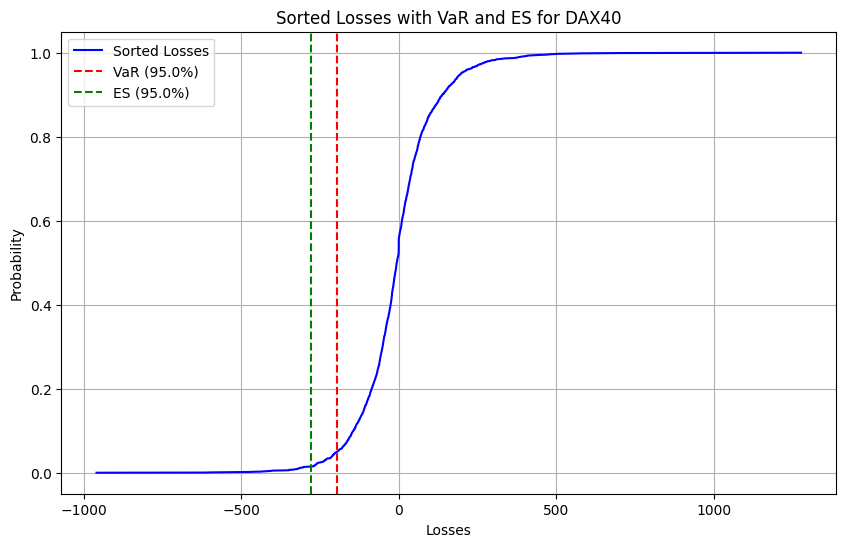

In [ ]:
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss'].dropna()

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index_dax40 = int((1 - confidence_level) * len(sorted_dax40_losses))

# Calculate VaR
VaR_dax40 = sorted_dax40_losses.iloc[var_index_dax40]

# Calculate ES (average of losses beyond VaR)
ES_dax40 = sorted_dax40_losses.iloc[:var_index_dax40].mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

import matplotlib.pyplot as plt

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: -2.945844
ES (Nikkei) at 95.0% confidence level: -4.238226520769231


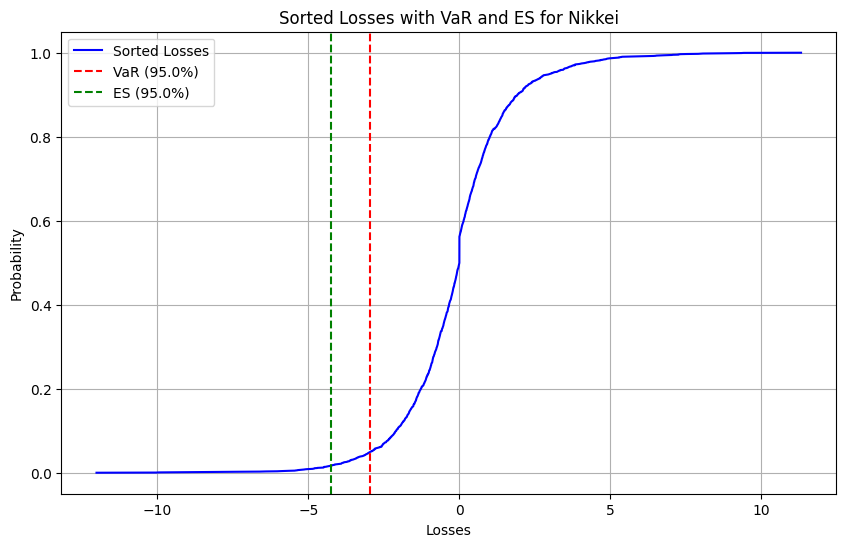

In [ ]:
# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss'].dropna()

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index_nikkei = int((1 - confidence_level) * len(sorted_nikkei_losses))

# Calculate VaR
VaR_nikkei = sorted_nikkei_losses.iloc[var_index_nikkei]

# Calculate ES (average of losses beyond VaR)
ES_nikkei = sorted_nikkei_losses.iloc[:var_index_nikkei].mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

import matplotlib.pyplot as plt

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()